In [1]:
import math
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.utils.np_utils import to_categorical
import tensorflow as tf



Using TensorFlow backend.


In [2]:
# Load the data
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

train_X = train.iloc[:,1:]
train_y = train['label']

print(train_X.shape)
print(train_y.shape)
print(test.shape)

del train 

(42000, 784)
(42000,)
(28000, 784)


In [3]:
train_y.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [4]:
train_X.isnull().sum().sum()

0

In [5]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
# Normalize the data
train_X = train_X / 255.0
test = test / 255.0

In [7]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
train_X = train_X.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [8]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
train_y = to_categorical(train_y, num_classes = 10)

In [9]:
# Split the train and the validation set for the fitting
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size = 0.2)


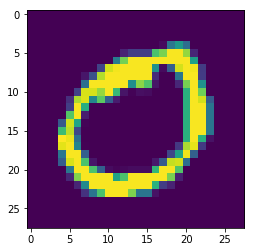

In [10]:
plt.imshow(train_X[0][:,:,0])

In [15]:
epochs = 100
batch_size = 64

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

opt = Adam(lr=0.007)

model.compile(optimizer = opt , loss = "categorical_crossentropy", metrics=["acc"])

In [ ]:

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, min_delta=1e-2, verbose=1, mode='auto', baseline=0.999)

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

datagen.fit(train_X)
with tf.device('/gpu:0'):
    # fits the model on batches with real-time data augmentation:
    history = model.fit_generator(datagen.flow(train_X, 
                                     train_y, 
                                     batch_size=batch_size),
                        validation_data = (val_X, val_y),
                        steps_per_epoch=len(train_X) // batch_size,
                        epochs=epochs,
                        callbacks=[reduce_lr, early_stopping])


Epoch 1/100
525/525 [==============================] - 150s 285ms/step - loss: 0.6668 - acc: 0.7789 - val_loss: 0.1156 - val_acc: 0.9658
Epoch 2/100
525/525 [==============================] - 149s 283ms/step - loss: 0.3090 - acc: 0.9076 - val_loss: 0.1091 - val_acc: 0.9674
Epoch 3/100
525/525 [==============================] - 147s 281ms/step - loss: 0.2710 - acc: 0.9210 - val_loss: 0.0939 - val_acc: 0.9693
Epoch 4/100
525/525 [==============================] - 149s 284ms/step - loss: 0.2619 - acc: 0.9228 - val_loss: 0.1083 - val_acc: 0.9683
Epoch 5/100
525/525 [==============================] - 150s 287ms/step - loss: 0.2727 - acc: 0.9219 - val_loss: 0.0812 - val_acc: 0.9758
Epoch 6/100
525/525 [==============================] - 149s 284ms/step - loss: 0.2592 - acc: 0.9264 - val_loss: 0.0902 - val_acc: 0.9738
Epoch 7/100
525/525 [==============================] - 150s 285ms/step - loss: 0.2588 - acc: 0.9261 - val_loss: 0.1095 - val_acc: 0.9696

Epoch 00007: ReduceLROnPlateau reducing 

In [ ]:
pred_y = model.predict(val_X)
print('RMSE = %.6f' % math.sqrt(mean_squared_error(pred_y, val_y)))


In [ ]:
sns.lineplot(x=range(len(history.history['val_acc'])), y=history.history['val_acc'], label='val_acc')
sns.lineplot(x=range(len(history.history['acc'])), y=history.history['acc'], label='acc')


In [ ]:
matrix = confusion_matrix(val_y.argmax(axis=1), pred_y.argmax(axis=1))

sns.heatmap(matrix, cbar=False, annot=True, fmt='d', cmap="Blues", square=True)


## Submission

In [ ]:
test_y = model.predict(test)
test_y = test_y.round()
out_label = [ np.argmax(i) for i in test_y]
out_imageid = [ i+1 for i in range(len(test_y))]
out = pd.DataFrame()
out['ImageId'] = out_imageid
out['Label'] = out_label

out.to_csv('submission.csv', index=False)
out